In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from time import clock
import matplotlib.pyplot as plt

In [2]:
class_data = pd.read_csv("winequality-red.csv", delimiter=";")
X, y = class_data.iloc[:,:-1], class_data.iloc[:,-1]-3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [3]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('clf', SVC())
])


# Set the parameters by cross-validation
tuned_parameters = [{'clf__kernel': ['rbf'], 'clf__gamma':  np.logspace(-2.0, 1.0, num=20),
                     'clf__C':  np.logspace(-1.0, 2.0, num=20)}#,
                    #{'clf__kernel': ['sigmoid'], 'clf__gamma': [1e2, 1e1, 1e0, 1e-1, 1e-2],
                     #'clf__C': [10, 100, 1000, 10000, 100000]},
                    #{'clf__kernel': ['linear'], 'clf__C': [10, 100, 1000, 10000, 100000]}
                   ]

model = GridSearchCV(pipeline, tuned_parameters, cv=4,
                   scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the estimator
start = clock()
model.fit(X_train, y_train)
stop = clock()
print('Time to hypertune: {:.3f}'.format(stop-start))

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   48.7s finished


Time to hypertune: 49.006


In [4]:
# Extract best hyperparameters from 'grid'
print('Best hyperparameters:\n', model.best_params_)

# Extract best CV score from 'grid'
print('Best CV accuracy: {:.3f}'.format(model.best_score_))

# Extract best model from 'grid'
best_model = model.best_estimator_

# Evaluate test set accuracy
test_acc = best_model.score(X_test, y_test)

# Print test set accuracy
print('Test set accuracy of best model: {:.3f}'.format(test_acc))

# Print CV confusion matrix
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Mean fit and score time for best parameters
print('Mean fit time: {:.4f}'.format(model.cv_results_['mean_fit_time'][model.best_index_]))
print('Mean score time: {:.4f}'.format(model.cv_results_['mean_score_time'][model.best_index_]))

Best hyperparameters:
 {'clf__C': 2.636650898730358, 'clf__gamma': 0.7847599703514611, 'clf__kernel': 'rbf'}
Best CV accuracy: 0.651
Test set accuracy of best model: 0.644
[[ 0  1  0  0  0  0]
 [ 0  1  6  6  0  0]
 [ 1  1 99 28  2  0]
 [ 0  1 35 88  6  1]
 [ 0  0  2 19 18  0]
 [ 0  0  1  1  3  0]]
Mean fit time: 0.1272
Mean score time: 0.0160


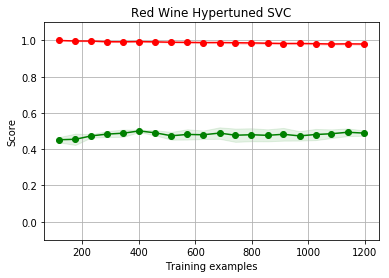

In [5]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, n_jobs=-1, shuffle=True, 
                                                        cv=4, train_sizes=np.linspace(.1, 1.0, 20), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Red Wine Hypertuned SVC")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()